In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessie/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/jessie/nltk_data...


True

In [5]:
#load the dataset
news_d = pd.read_csv("train.csv")
print("Shape of News data:", news_d.shape)
print("News data colimns:", news_d.columns)

Shape of News data: (20800, 5)
News data colimns: Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [7]:
#text(column) word startistics
txt_length = news_d.text.str.split().str.len()
txt_length.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [8]:
#title(column) word startistics
title_length = news_d.title.str.split().str.len()
title_length.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

1 : Unreliable
0 : Reliable
Distribrtion of labels
label
1    10413
0    10387
Name: count, dtype: int64


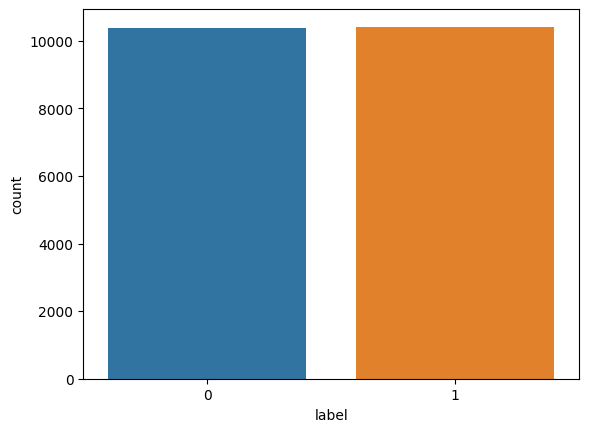

In [11]:
#counting plots for both labels
sns.countplot(x = "label", data = news_d)
print("1 : Unreliable")
print("0 : Reliable")
print("Distribrtion of labels")
print(news_d.label.value_counts())

In [12]:
#Data cleaning:
#Drop unused rows and columns
#Perform null value imputation
#Remove special characters
#Remove stop words


In [13]:
# Constants that are used to sanitize the datasets 

column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

In [15]:
import nltk
from  nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

In [20]:
#Removed unusd columns
def remove_unused_columns(data, column_n = remove_c):
    data = data.drop(column_n, axis = 1)
    return data

#Replaced null values = "None"
def null_process(data):
    for col in text_f:
        data.loc[data[col].isnull(), col] = "None"
    return data

def clean_data(data):
    data = remove_unused_columns(data)
    data = null_process(data)
    return data

#Cleaning text from unuesd characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return text

In [21]:
#Perform data cleaning on train and test dataset by calling function
filted_d = clean_data(news_d)
filted_d["text"] = filted_d.text.apply(nltk_preprocess)
filted_d["title"] = filted_d.title.apply(nltk_preprocess)
filted_d.head()

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


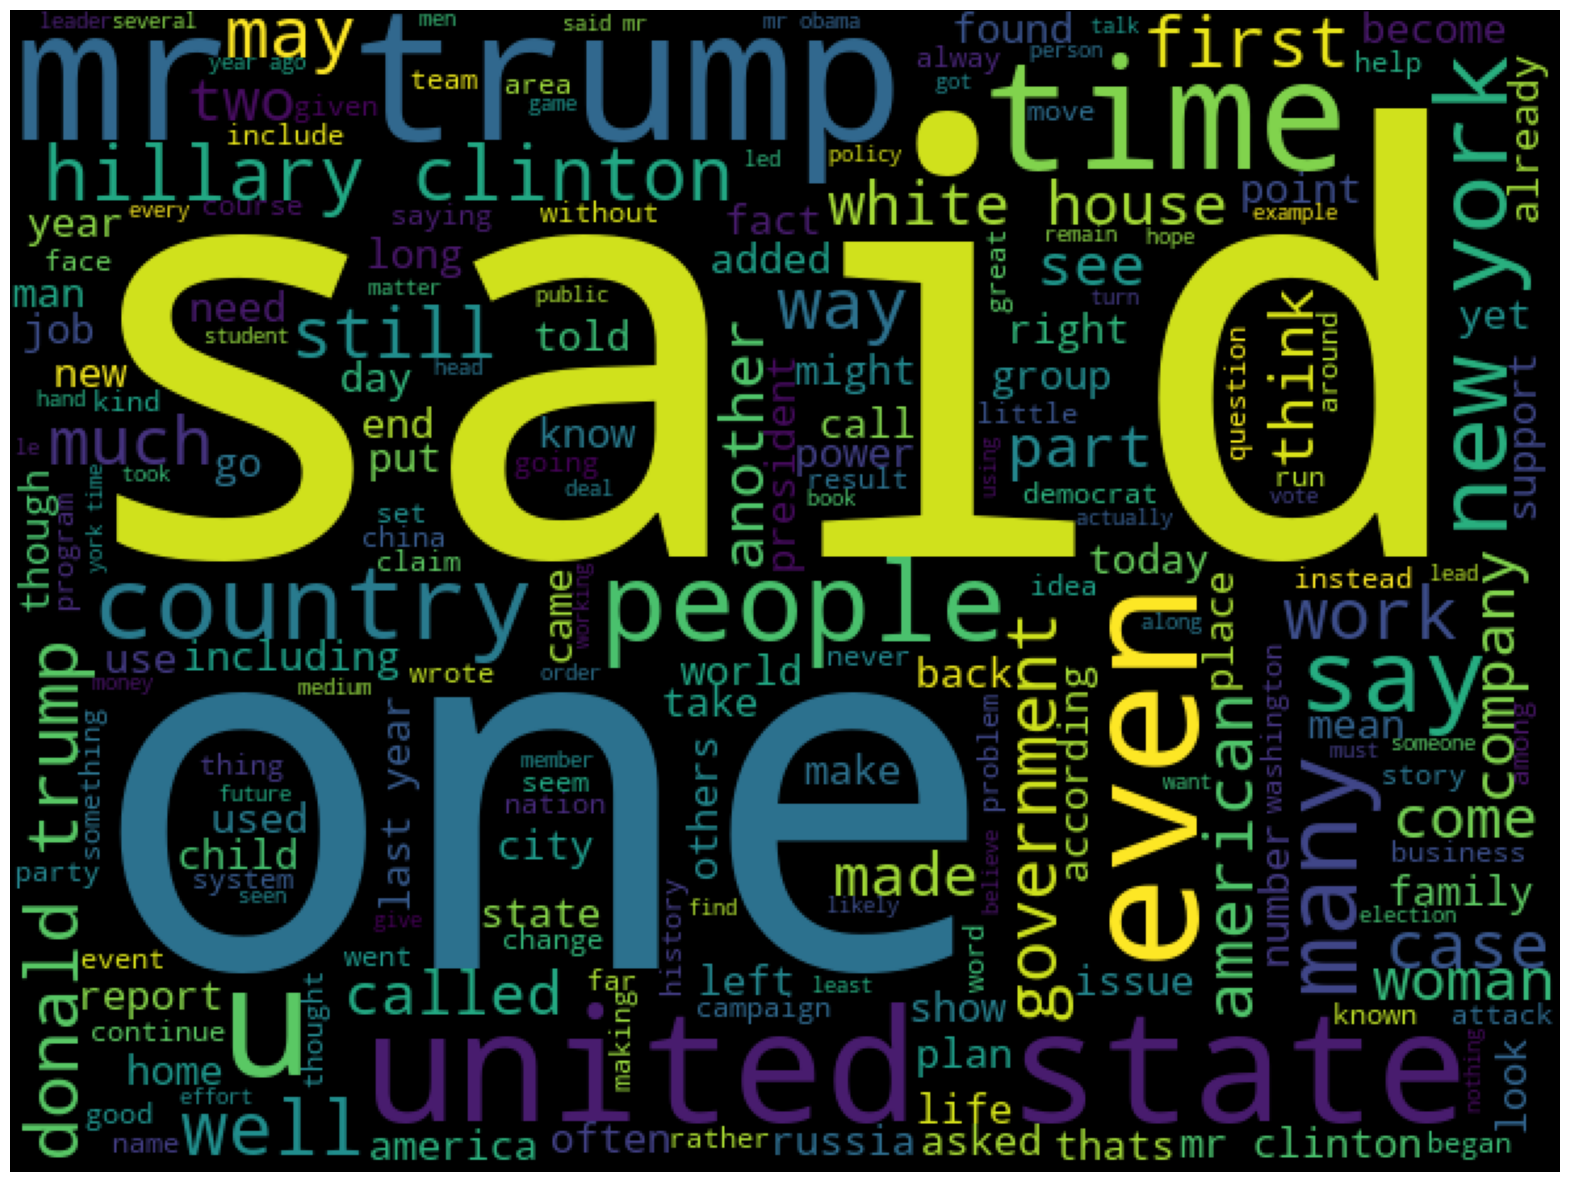

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#initialize the word cloud
wordcloud = WordCloud(background_color = 'black', width = 640, height = 480)
#Ganerate the wordcloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(filted_d['text']))
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

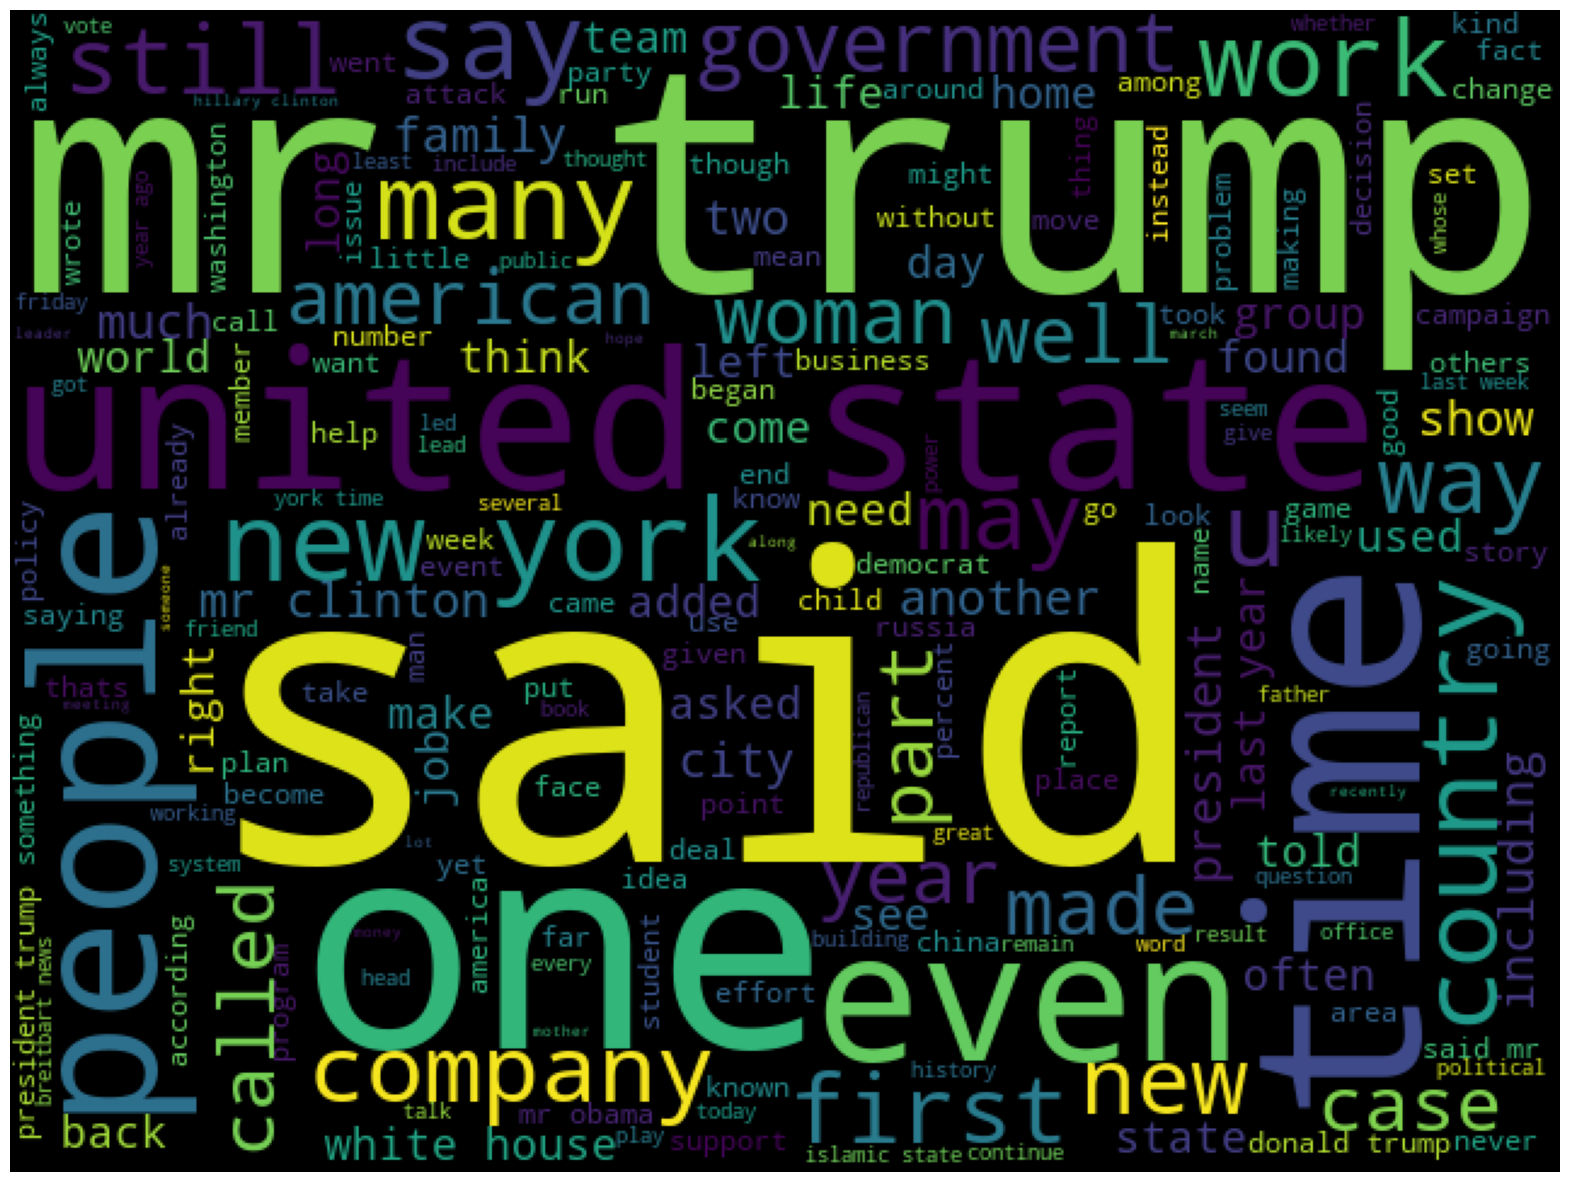

In [28]:
true_n = ' '.join(filted_d[filted_d['label']==0]['text']) 
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

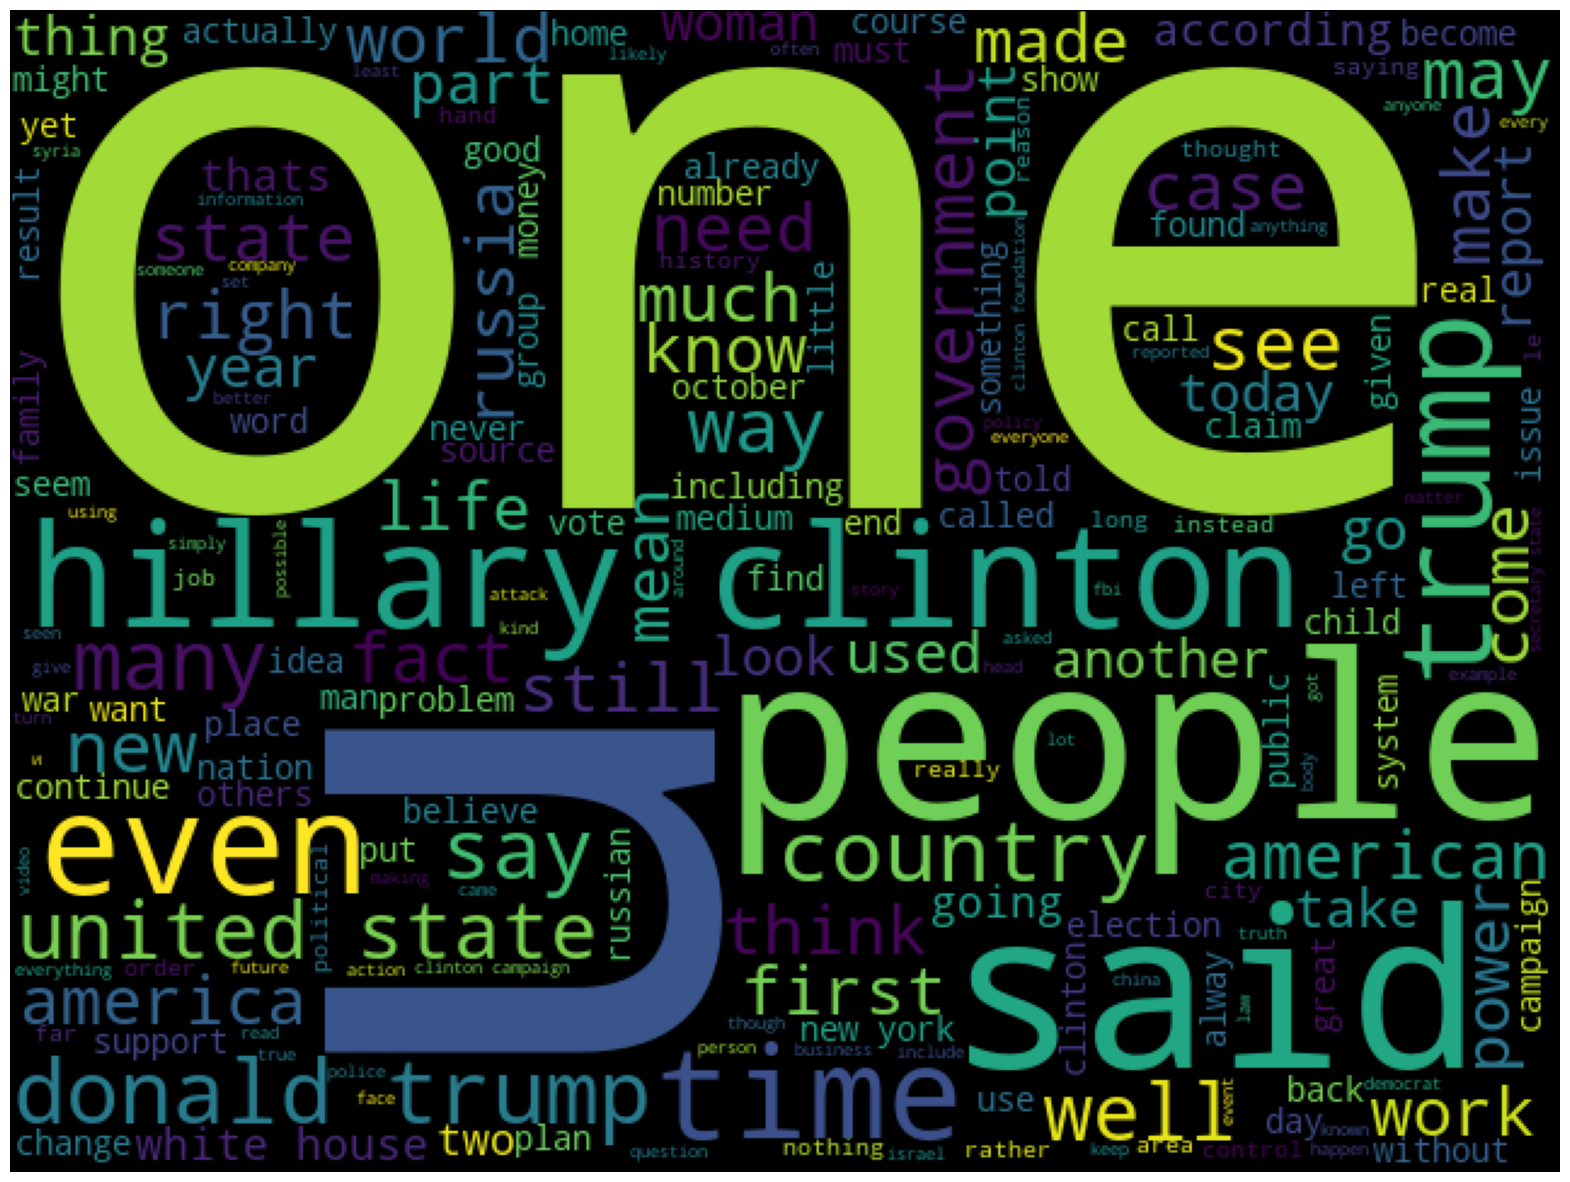

In [29]:
fake_n = ' '.join(filted_d[filted_d['label']==1]['text'])
wc= wordcloud.generate(fake_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

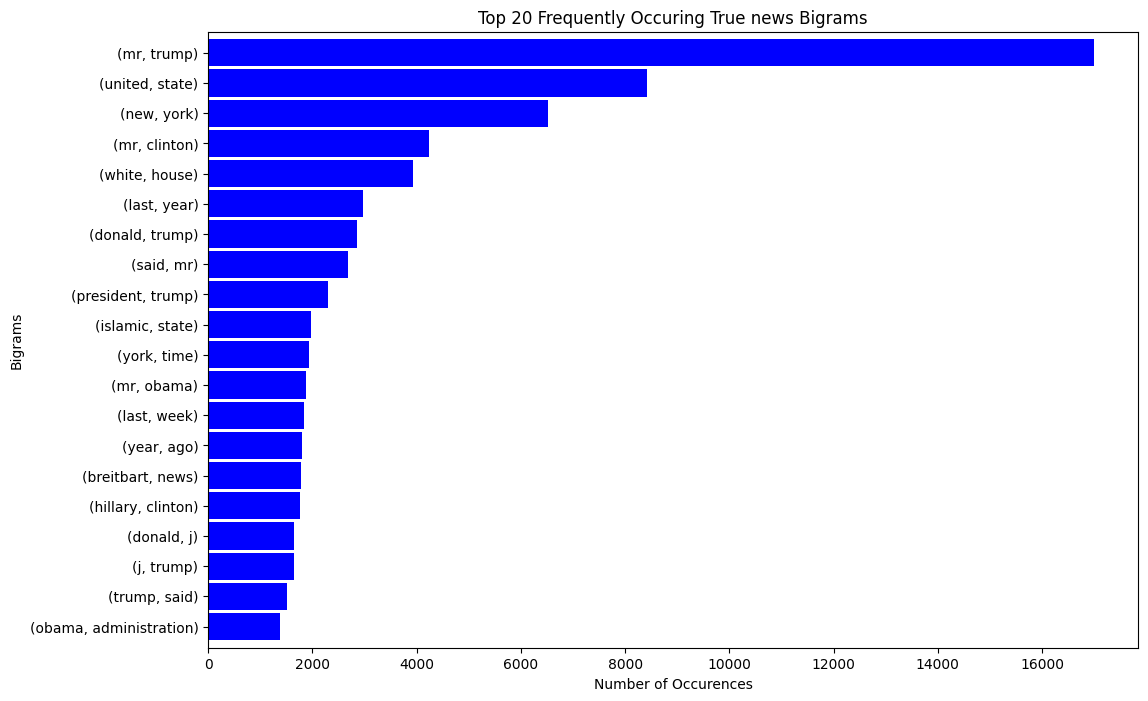

In [34]:
#Most frequent two-word combination
def most_frequent_two_word_combination(corpus, title, ylabel, xlabel = "Number of Occurences", n = 2):
    true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
    true_b.sort_values().plot.barh(color = 'blue', width = .9, figsize = (12, 8))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

most_frequent_two_word_combination(true_n, "Top 20 Frequently Occuring True news Bigrams", "Bigrams", n = 2)

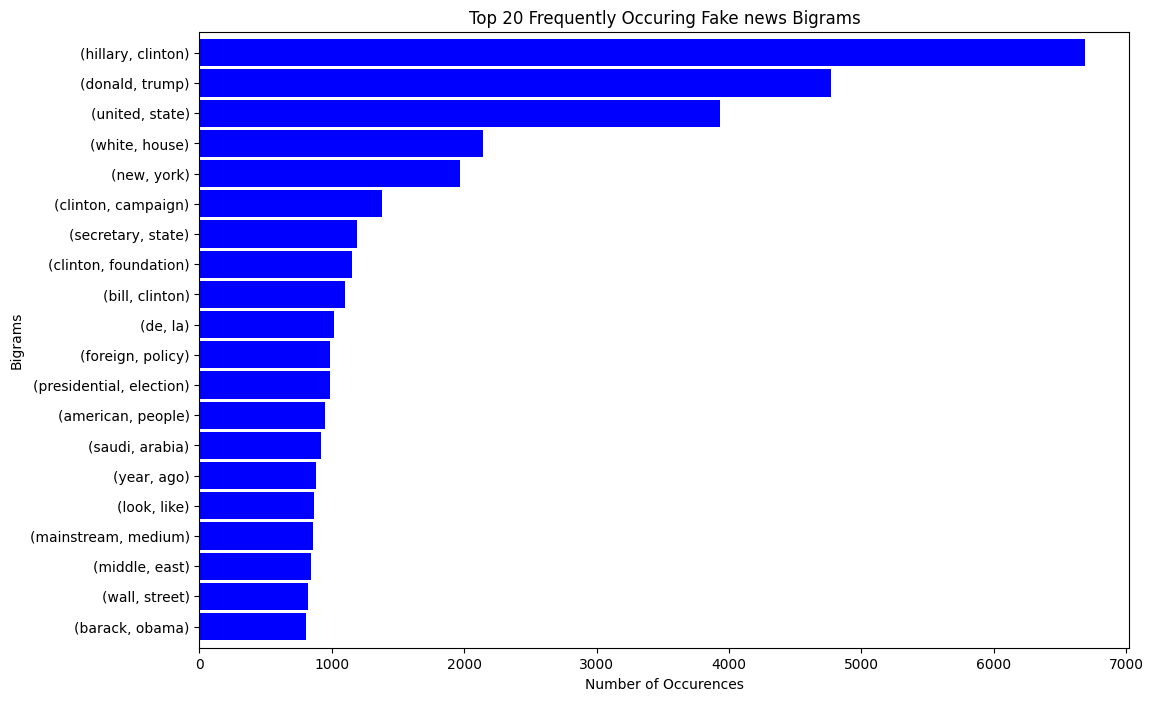

In [35]:
most_frequent_two_word_combination(fake_n, "Top 20 Frequently Occuring Fake news Bigrams", "Bigrams", n = 2)

In [37]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random

In [38]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
set_seed(1)

In [39]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [40]:
#transform data to vector
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case = True)

In [41]:
#Data Preparation
news_df = news_d[news_d['text'].notna()] #Remove null values
news_df = news_df[news_df['author'].notna()]
news_df = news_df[news_df['title'].notna()]

In [1]:
def prepare_data(data, test_size = 0.2, include_title = True, include_author = True):
    texts = []
    labels = []
    for i in range(len(data)):
        text = data["text"].iloc[i]
        label = data["label"].iloc[i]
        if include_title:
            text =  data["title"].iloc[i] + " - " + text
        if include_author:
            text =  data["author"].iloc[i] + " : " + text
        if text and label in [0, 1]:
            texts.append(text)
            labels.append(label)
    return train_test_split(texts, labels, test_size = test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(news_df)

NameError: name 'news_df' is not defined

In [43]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [47]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [49]:
#Load AI model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [50]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [52]:
training_args = TrainingArguments(
    output_dir = './results',          # output directory
    num_train_epochs = 1,              # total number of training epochs
    per_device_train_batch_size = 10,  # batch size per device during training
    per_device_eval_batch_size = 20,   # batch size for evaluation
    warmup_steps = 100,                # number of warmup steps for learning rate scheduler
    logging_dir = './logs',            # directory for storing logs
    load_best_model_at_end = True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps = 200,               # log & save weights each logging_steps
    save_steps = 200,
    evaluation_strategy = "steps",     # evaluate each `logging_steps`
)

In [54]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train the model accoring to the settings
trainer.train()

KeyboardInterrupt: 

In [55]:
# evaluate the current model after training
trainer.evaluate()

KeyboardInterrupt: 

In [62]:
# saving the fine tuned model & tokenizer
model_path = "fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# model.from_pretrained(model_path)
# tokenizer.from_pretrained(model_path)

BertTokenizerFast(name_or_path='fake-news-bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [63]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "reliable",
        1: "fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [57]:
real_news = """
Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman   quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. <SNIPPED>
"""

In [65]:
print(get_prediction(real_news, convert_to_label=True))

AssertionError: Torch not compiled with CUDA enabled